<a href="https://colab.research.google.com/github/coryroyce/code_assignments/blob/main/211031_Dimensionality_Reduction/Dimensionality_Reduction_Cory_Randolph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dimensionality Reduction
Cory Randolph
10/29/2021

Goal: Demonstrate several different methods of dimensionality reduction with tabular data and also image data.

# Load Packages

Install needed packages for this project

In [109]:
# Install the emnist package for loading image data easily
!pip install emnist
!pip install umap-learn

# Clear output for this cell
from IPython.display import clear_output
clear_output()

Import packages used

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn import datasets
import umap

# Load Datasets

## Tabular Data

Load in tabular data that will be used for the various dimensionality reduction techniques


In [111]:
iris = datasets.load_iris()

df_features_tabular = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df_labels_tabular = pd.DataFrame(iris.target + 1, columns= ['label'])
# Note: Added +1 to the label since 0 was having a missing color in some graphs


In [112]:
df_features_tabular.shape

(150, 4)

In [113]:
df_features_tabular.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [114]:
df_labels_tabular.head(3)

,label
0,1
1,1
2,1


## Image Data


For this project I chose to do the EMNIST data set since it is less used in examples and tutorials normally just the numerical data set is used.



In [115]:
import emnist

Display the datasets included in emnist

In [116]:
print(emnist.list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


For this project I will focust on just the letters data set with balanced class examples conataining 145,600 examples. (Smaller subsets may be taken later for visualization)

In [117]:
x,y = emnist.extract_training_samples('letters')
# Since this project just focuses on the pre-process and dimensionaluty reduction we will not need the below test set for model development.
# x_train,y_train = emnist.extract_training_samples('letters')
# x_test,y_test = emnist.extract_test_samples('letters')

Show that there 26 unique labels

In [118]:
len(np.unique(y))

26

Create the list of labels rather than the provided integer value

In [119]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
labels_dict = {key+1: value for key, value in enumerate(labels)}

Create a Pandas Dataframe for the data

In [120]:
def create_emnist_df(x,y,labels_dict):
  # Define the pixel values as a dataframe
  image_vector_size = 28*28
  x_flattened = x.reshape(x.shape[0], image_vector_size)
  df_features = pd.DataFrame(x_flattened)

  # Define the label column
  df_labels = pd.DataFrame(y, columns=['label'])
  # Map the labels from the integers
  df_labels['label'] = df_labels['label'].map(labels_dict)

  # Merege the features and labels
  # df = pd.merge(df_labels, df_df_features, left_index=True, right_index=True)

  return df_features, df_labels

In [121]:
df_features, df_labels = create_emnist_df(x,y,labels_dict)
df_features.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [122]:
df_labels.head(3)

,label
0,W
1,G
2,P


Create a smaller subset of features since some methods are computationaly expensive

In [123]:
def get_subset_of_image_data(df_features, df_labels):
  df_temp = pd.merge(df_labels, df_features, left_index=True, right_index=True)

  # Get stratified subset of 100 of each characters
  df_sample = df_temp.groupby('label', group_keys = False).apply(lambda x: x.sample(100))
  df_sample.reset_index(drop = True, inplace = True)

  # Separate featuers from lables
  df_labels_temp = pd.DataFrame(df_sample, columns=['label'])
  df_features_temp = df_sample.drop('label', axis = 1)

  return df_features_temp, df_labels_temp


In [124]:
# Apply the subset function to reduce the data set to a balanced 2,600 records (100 of each letter)
df_features, df_labels = get_subset_of_image_data(df_features, df_labels)

print(f'The sampled dataframes now have {df_features.shape[0]:,}')

The sampled dataframes now have 2,600


Plot the first data point to verify

In [125]:
def plot_emnist_image_by_idx(idx):
  plt.figure(figsize=(4,4))
  # Reshape the dataframe from 1d to 2d pixel array for given idx (prefer 28 X 28)
  grid_data = df_features.loc[idx].values.reshape(28,28)
  # Plot above grid image with cmap as gray and interpoltion as none
  plt.imshow(grid_data, interpolation='none', cmap='gray')

  #display plot
  plt.show()

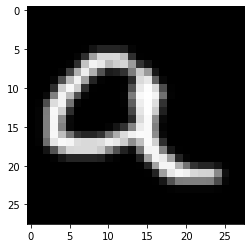

In [126]:
idx = 2
plot_emnist_image_by_idx(idx)

# Image Data Reduction

## Principle Component Analysis (PCA)

Apply PCA to the emnist letter data set

Standarize the data

In [127]:
df_standard = StandardScaler().fit_transform(df_features)
print(f'df_standrd has {df_standard.shape[0]:,} rows and {df_standard.shape[1]} columns.')

df_standrd has 2,600 rows and 784 columns.


Instantiate a PCA model from sklearn

In [128]:
pca = decomposition.PCA() # decomposition was imported above from sklearn

# Set the numer of components (2 for 2D visualizations)
pca.n_components = 2

# Fit the PCA model on the data
pca_fitted = pca.fit_transform(df_standard)
print(f'pca_fitted has {pca_fitted.shape[0]:,} rows and {pca_fitted.shape[1]} columns.')

pca_fitted has 2,600 rows and 2 columns.


Create a new dataframe for plotting

In [129]:
# Need to add in the Letter index's for colring in the plot
labels_dict_reveresed = {value : key for (key, value) in labels_dict.items()}


df_pca = pd.DataFrame({'1st Principal Component' : pca_fitted.T[0],
                       '2nd Principal Component' : pca_fitted.T[1],
                       'label' : df_labels['label'],
                       'label_int' : df_labels['label'].map(labels_dict_reveresed)})

In [130]:
df_pca.head()

,1st Principal Component,2nd Principal Component,label,label_int
0,3.148538,9.400114,A,1
1,-2.987663,-1.734974,A,1
2,3.875522,9.368687,A,1
3,-0.331570,4.826886,A,1
4,10.401074,-3.061973,A,1


Plot the PCA data in 2D with Seaborn

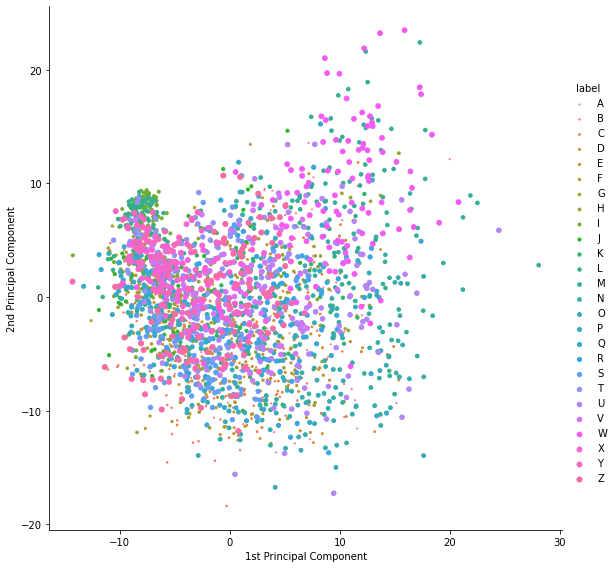

In [131]:
sns.FacetGrid(df_pca, hue='label',height=8).map(plt.scatter, '1st Principal Component', '2nd Principal Component', 'label_int').add_legend()
plt.show()

Plot the variance explained by the various number of components

In [132]:
pca.n_components = 784

pca_fitted = pca.fit_transform(df_standard)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

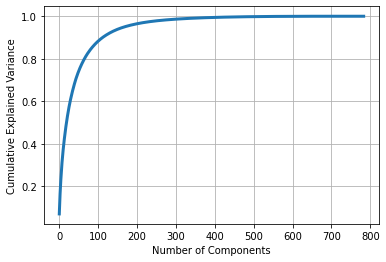

In [133]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Based on this graph we get ~95% of the data at 200 components.
We could do an other PCA with n = 200 and re plot the before an after image to see the "data loss" through PCA.

## Singular Value Decomposition (SVD)

Apply SVD to the image data set

In [134]:
svd = decomposition.TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_fitted = svd.fit_transform(df_standard)

print(f'svd_fitted has {svd_fitted.shape[0]:,} rows and {svd_fitted.shape[1]} columns.')

svd_fitted has 2,600 rows and 2 columns.


Create a new dataframe for plotting

In [135]:
# Need to add in the Letter index's for colring in the plot
labels_dict_reveresed = {value : key for (key, value) in labels_dict.items()}


df_svd = pd.DataFrame({'1st Component' : svd_fitted.T[0],
                       '2nd Component' : svd_fitted.T[1],
                       'label' : df_labels['label'],
                       'label_int' : df_labels['label'].map(labels_dict_reveresed)})

In [136]:
df_svd.head()

,1st Component,2nd Component,label,label_int
0,3.148468,9.399384,A,1
1,-2.987977,-1.735535,A,1
2,3.875693,9.369109,A,1
3,-0.331347,4.828125,A,1
4,10.400169,-3.064448,A,1


Plot the SVD data in 2D with Seaborn

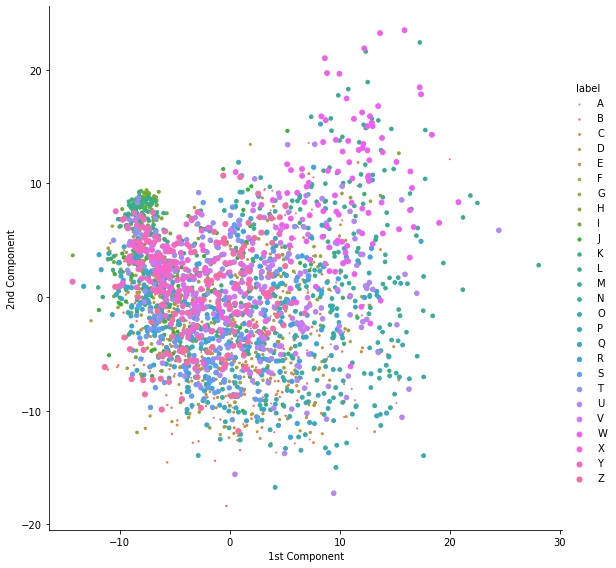

In [137]:
sns.FacetGrid(df_svd, hue='label',height=8).map(plt.scatter, '1st Component', '2nd Component', 'label_int').add_legend()
plt.show()

Check the explained variance ratio with using just 2 compnoents in SVD

In [138]:
svd.explained_variance_ratio_.sum()

0.12260822051233841

Plot the variance explained by the various number of components

In [139]:
svd.n_components = 783

svd_fitted = svd.fit_transform(df_standard)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

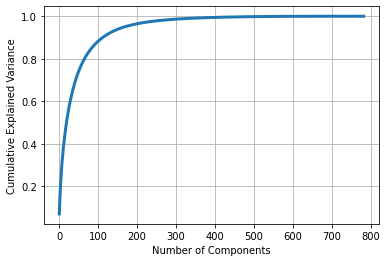

In [140]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Plot looks vary similar to the PCA version with just 2 compnents

## Locally Linear Embedding (LLE)

Apply LLE to the image data

In [141]:
embeding = manifold.LocallyLinearEmbedding(n_components=2)
lle_fitted = embeding.fit_transform(df_features)

Plot the transformed data

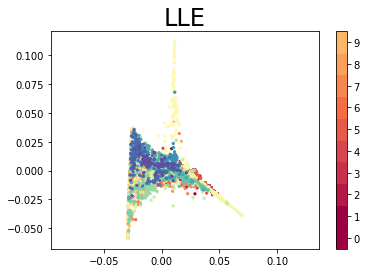

In [142]:
plt.scatter(lle_fitted[:, 0], lle_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('LLE', fontsize=24);

## t-distributed Stochastic Neighbor Embedding (t_SNE)

Apply t-SNE to image data.

Regerence [notebook](https://www.kaggle.com/parulpandey/visualizing-kannada-mnist-with-t-sne) from Parul Pandey

In [143]:
tsne = manifold.TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(df_features)

Plot the data

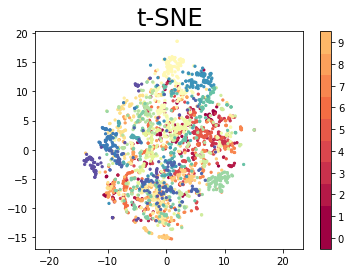

In [144]:
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE', fontsize=24);

## Isometric Mapping (ISOMAP)

Apply ISOMAP to the image data set

In [145]:
isomap = manifold.Isomap(n_components=2)
isomap_fitted = isomap.fit_transform(df_features)
isomap_fitted.shape

(2600, 2)

Plot the data

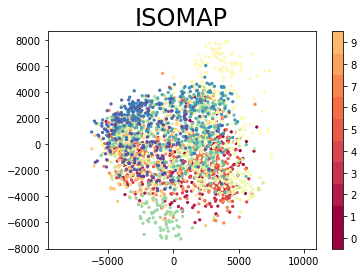

In [146]:
plt.scatter(isomap_fitted[:, 0], isomap_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('ISOMAP', fontsize=24);

## Uniform Manifold Approximation and Projection (UMAP)

Apply UMAP to image dataset

In [147]:
umap_model = umap.UMAP(n_components=2)
umap_fitted = umap_model.fit_transform(df_features)
umap_fitted.shape

(2600, 2)

Plot the data

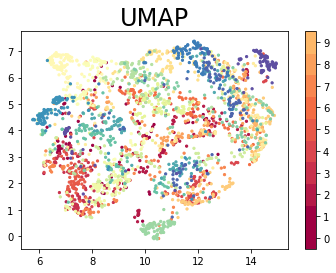

In [148]:
plt.scatter(umap_fitted[:, 0], umap_fitted[:, 1], s= 5, c=df_labels['label'].map(labels_dict_reveresed), cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=24);

UMAP Looks much Better than the the ISOMAP since there are more distinct clusters.

# Tabular Data Reduction

## Principle Component Analysis (PCA)

Apply PCA to the tabular iris dataset

Standarize the data

In [149]:
df_standard_tabular = StandardScaler().fit_transform(df_features_tabular)
print(f'df_standard_tabular has {df_standard_tabular.shape[0]:,} rows and {df_standard_tabular.shape[1]} columns.')

df_standard_tabular has 150 rows and 4 columns.


Instantiate a PCA model from sklearn

In [150]:
pca = decomposition.PCA() # decomposition was imported above from sklearn

# Set the numer of components (2 for 2D visualizations)
pca.n_components = 2

# Fit the PCA model on the data
pca_fitted = pca.fit_transform(df_standard_tabular)
print(f'pca_fitted has {pca_fitted.shape[0]:,} rows and {pca_fitted.shape[1]} columns.')

pca_fitted has 150 rows and 2 columns.


Create a new dataframe for plotting

In [151]:
df_pca = pd.DataFrame({'1st Principal Component' : pca_fitted.T[0],
                       '2nd Principal Component' : pca_fitted.T[1],
                       'label' : df_labels_tabular['label']})

In [152]:
df_pca.head(3)

,1st Principal Component,2nd Principal Component,label
0,-2.264703,0.480027,1
1,-2.080961,-0.674134,1
2,-2.364229,-0.341908,1


Plot the PCA data in 2D with Seaborn

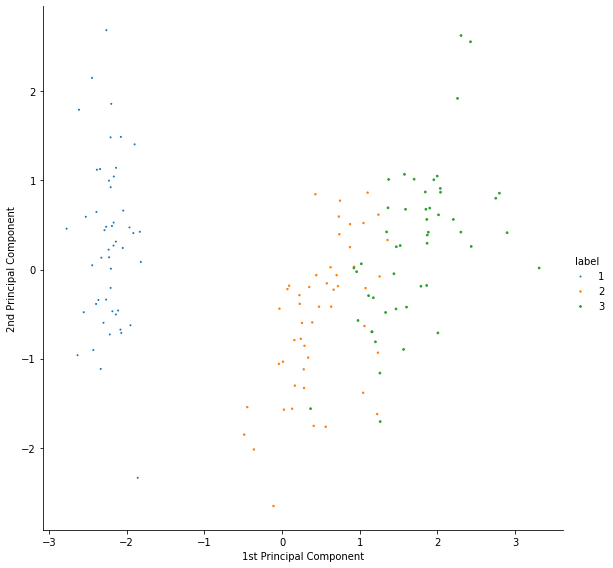

In [153]:
sns.FacetGrid(df_pca, hue='label',height=8).map(plt.scatter, '1st Principal Component', '2nd Principal Component', 'label').add_legend()
plt.show()

Plot the variance explained by the various number of components

In [154]:
pca.n_components = 4

pca_fitted = pca.fit_transform(df_standard_tabular)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

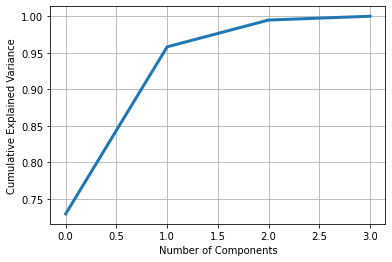

In [155]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Based on this graph we get ~95% of the data with just a single component.

## Singular Value Decomposition (SVD)

Apply SVD to the image data set

In [156]:
svd = decomposition.TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_fitted = svd.fit_transform(df_standard_tabular)

print(f'svd_fitted has {svd_fitted.shape[0]:,} rows and {svd_fitted.shape[1]} columns.')

svd_fitted has 150 rows and 2 columns.


Create a new dataframe for plotting

In [157]:
df_svd = pd.DataFrame({'1st Component' : svd_fitted.T[0],
                       '2nd Component' : svd_fitted.T[1],
                       'label' : df_labels_tabular['label']})

In [158]:
df_svd.head()

,1st Component,2nd Component,label
0,-2.264703,0.480027,1
1,-2.080961,-0.674134,1
2,-2.364229,-0.341908,1
3,-2.299384,-0.597395,1
4,-2.389842,0.646835,1


Plot the SVD data in 2D with Seaborn

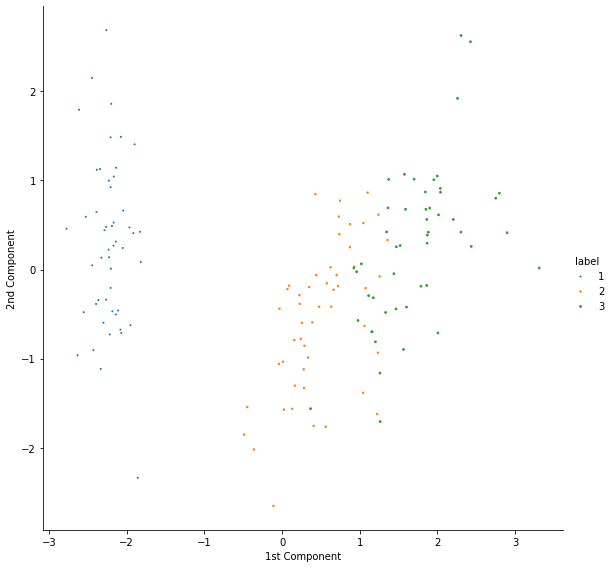

In [159]:
sns.FacetGrid(df_svd, hue='label',height=8).map(plt.scatter, '1st Component', '2nd Component', 'label').add_legend()
plt.show()

Check the explained variance ratio with using just 2 compnoents in SVD

In [160]:
svd.explained_variance_ratio_.sum()

0.9581320720000164

Plot the variance explained by the various number of components

In [161]:
svd.n_components = 3

svd_fitted = svd.fit_transform(df_standard_tabular)

percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)

#cumulative sum of the percentage_var_explained
cumulative_explained_variance = np.cumsum(percentage_var_explained)

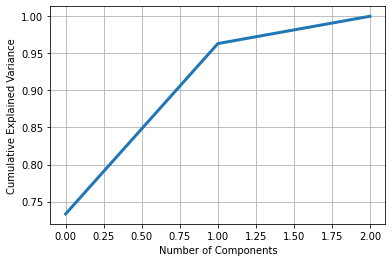

In [162]:
plt.figure(figsize=(6,4))
plt.plot(cumulative_explained_variance,linewidth=3)
plt.grid()

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

Plot looks vary similar to the PCA version with just 2 compnents

## Locally Linear Embedding (LLE)

Apply LLE to the image data

In [166]:
embeding = manifold.LocallyLinearEmbedding(n_components=2)
lle_fitted = embeding.fit_transform(df_features_tabular)

Plot the transformed data

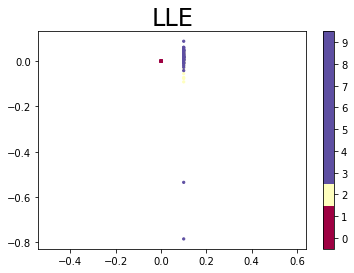

In [170]:
plt.scatter(lle_fitted[:, 0], lle_fitted[:, 1], s= 5, c=df_labels_tabular['label'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('LLE', fontsize=24);

## t-distributed Stochastic Neighbor Embedding (t_SNE)

Apply t-SNE to image data.

Regerence [notebook](https://www.kaggle.com/parulpandey/visualizing-kannada-mnist-with-t-sne) from Parul Pandey

In [171]:
tsne = manifold.TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(df_features_tabular)

Plot the data

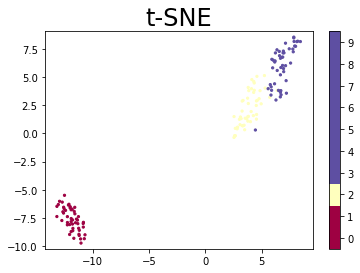

In [172]:
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=df_labels_tabular['label'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE', fontsize=24);

## Isometric Mapping (ISOMAP)

Apply ISOMAP to the image data set

In [173]:
isomap = manifold.Isomap(n_components=2)
isomap_fitted = isomap.fit_transform(df_features_tabular)
isomap_fitted.shape

(150, 2)

Plot the data

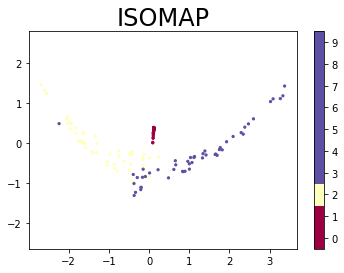

In [174]:
plt.scatter(isomap_fitted[:, 0], isomap_fitted[:, 1], s= 5, c=df_labels_tabular['label'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('ISOMAP', fontsize=24);

## Uniform Manifold Approximation and Projection (UMAP)

Apply UMAP to image dataset

In [175]:
umap_model = umap.UMAP(n_components=2)
umap_fitted = umap_model.fit_transform(df_features_tabular)
umap_fitted.shape

(150, 2)

Plot the data

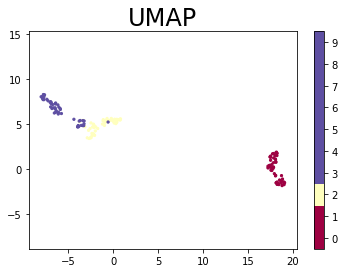

In [176]:
plt.scatter(umap_fitted[:, 0], umap_fitted[:, 1], s= 5, c=df_labels_tabular['label'], cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP', fontsize=24);

UMAP Looks much Better than the the ISOMAP since there are more distinct clusters.

# Reference
EMNIST dataset: https://www.nist.gov/itl/iad/image-group/emnist-dataset

Direct download: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip

Cohen, G., Afshar, S., Tapson, J., & van Schaik, A. (2017). EMNIST: an extension of MNIST to handwritten letters. Retrieved from http://arxiv.org/abs/1702.05373

Importing and formating Image data inspired by [ArangurenAndres/EMNSIT-Image-classification](https://github.com/ArangurenAndres/EMNSIT-Image-classification/blob/master/cognition_project.ipynb)

Parts of the visualation nad PCA were inspired by [Rahul228646's Kaggle notebook](https://www.kaggle.com/rahul228646/pca-mnist)

Example Data Visualizations for Images from [Kaggle Notebook](https://www.kaggle.com/parulpandey/visualizing-kannada-mnist-with-t-sne)


